#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [4]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1DC5XpNvdd5mm7g1g3yjThaVePddvR-Sw',
    'train_small': '1pLD-YC--D1PD5c5INoDDHWS_GP0t8Uig',
    'train_tiny': '16wbZo4TWGswomere6NRE7hdoFB1YeewB',
    'test': '10Gsaf8-gtzKiX5z0QjDoeqB0F1soSRDd',
    'test_small': '1YpgQKNOy9nk4RnvVR6FikpjW00Jsb5VU',
    'test_tiny': '1JJABKFaDaxJsaqDG171BzcL_mVVY1HaU'
}

In [ ]:
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [5]:
!pip install -q libtiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import gdown
import matplotlib.pyplot as plt
import time

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:
    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        if not Path(f'{name}.npz').exists():
            url = f'https://drive.google.com/uc?id={DATASETS_LINKS[name]}'
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)

        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])

        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset

        return self.image(i), self.labels[i]

### Загрузка датасетов
Загрузим датасеты:


* `train_tiny` и `test_tiny` для отладки построенной модели


*   `train_small` и `test_small` для первичного тестирования модели

*  `train` и `test` для финального тестирования модели



In [28]:
d_train_tiny = Dataset('train_tiny')
d_test_tiny = Dataset('test_tiny')

Downloading...
From (uriginal): https://drive.google.com/uc?id=16wbZo4TWGswomere6NRE7hdoFB1YeewB
From (redirected): https://drive.google.com/uc?id=16wbZo4TWGswomere6NRE7hdoFB1YeewB&confirm=t&uuid=46907708-c778-4f79-936f-6480728d5283
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 26.4MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


In [7]:
d_train_small = Dataset('train_small')
d_test_small = Dataset('test_small')

Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.
Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [8]:
d_train = Dataset('train')
d_test = Dataset('test')

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Построение модели классификации

В данном разделе представлены примеры работы аугментации данных, а также реализован сам класс Model, содержащий модель классификации.

##### Аугментация данных

In [10]:
#LBL1 -- аугментация данных
data_augmentation_layer = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomFlip('vertical'),
            tf.keras.layers.RandomRotation(0.2),
            ])

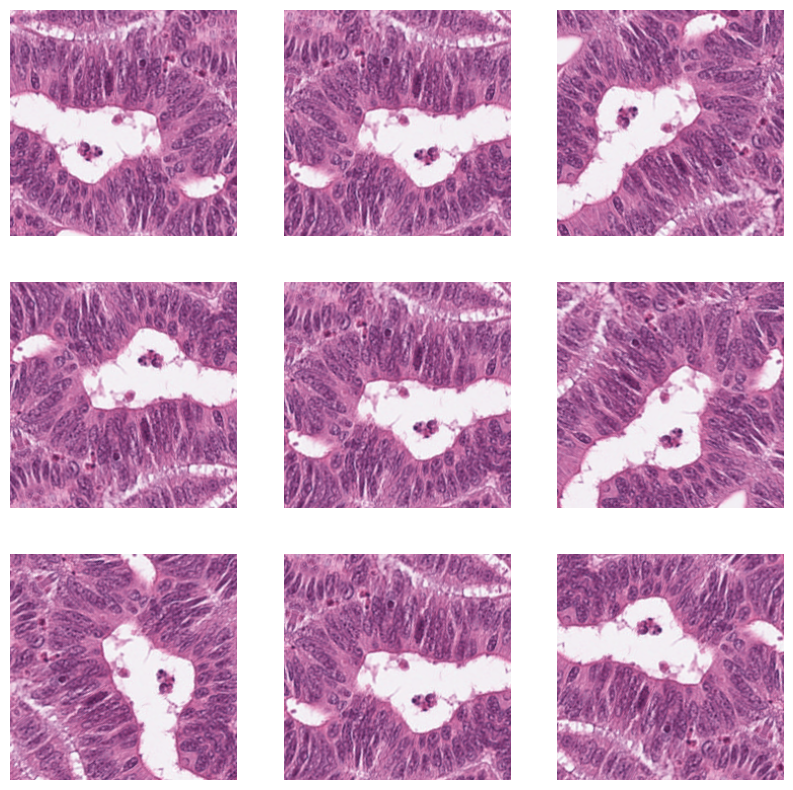

In [11]:
plt.figure(figsize=(10, 10))
image, _ = d_train.random_image_with_label()
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation_layer(tf.expand_dims(image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

##### Класс Model

In [18]:
class Model:
    def __init__(self):
        IMG_SIZE = (224, 224)
        IMG_SHAPE = IMG_SIZE + (3,)
        self.base_learning_rate = 0.0001
        self.initial_epochs = 10
        self.fine_tune_epochs = 10
        self.total_epochs =  self.initial_epochs + self.fine_tune_epochs
        self.history = None
        self.history_fine = None
        #модель -- ResNet50 с предобученными весами на датасете imagenet
        self.base_model = tf.keras.applications.resnet50.ResNet50(
            input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        data_augmentation = data_augmentation_layer
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        prediction_layer = tf.keras.layers.Dense(9, activation='softmax', kernel_initializer='he_normal')
        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = data_augmentation(inputs)
        x = preprocess_input(x)
        x = self.base_model(x, training=False)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = prediction_layer(x)
        self.model = tf.keras.Model(inputs, outputs)


    def save(self, name: str):
        self.model.save(f'drive/MyDrive/dl/{name}')

    def load(self, name: str):
        name_to_id_dict = {
            'small-trained': '1-KlwlZ6yy_nak_kd94ykwYXrAAwepgpD'
        }
        url = f'https://drive.google.com/drive/folders/{name_to_id_dict[name]}'
        gdown.download_folder(url, quiet=True, output=name, use_cookies=False)
        self.model = tf.keras.models.load_model(name)


    def train(self, dataset: Dataset):
        self.base_model.trainable = False
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.base_learning_rate),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy'])
        #LBL2 -- валидация на части обучающей выборки
        x_train, x_val, y_train, y_val = train_test_split(dataset.images, dataset.labels, test_size=0.25, random_state=42)
        del dataset
        self.history = self.model.fit(x_train, y_train,
                                epochs=self.initial_epochs,
                                validation_data=(x_val, y_val))
        self.base_model.trainable = True
        fine_tune_at = 150
        for layer in self.base_model.layers[:fine_tune_at]:
            layer.trainable = False
        self.model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.base_learning_rate/10),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
        self.history_fine = self.model.fit(x_train, y_train,
                                epochs=self.total_epochs,
                                initial_epoch=self.history.epoch[-1],
                                validation_data=(x_val, y_val))

    #LBL3 -- визуализация процесса обучения
    def trainig_plots(self):
        acc = self.history.history['accuracy'] + self.history_fine.history['accuracy']
        val_acc = self.history.history['val_accuracy'] + self.history_fine.history['val_accuracy']
        loss = self.history.history['loss'] + self.history_fine.history['loss']
        val_loss = self.history.history['val_loss'] + self.history_fine.history['val_loss']
        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.ylim([0, 1])
        plt.plot([self.initial_epochs-1,self.initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.ylim([0, 3.0])
        plt.plot([self.initial_epochs-1,self.initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()


    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        img = img.reshape(1,224,224,3)
        prediction = self.model(img, training=False)
        label = tf.argmax(prediction[0])
        return label

##### Обучение модели на датасете train_tiny

In [32]:
model_trained_on_tiny = Model()
model_trained_on_tiny.train(d_train_tiny)

Epoch 1/10
22/22 [==============================] - 8s 221ms/step - loss: 2.3028 - accuracy: 0.2000 - val_loss: 1.8755 - val_accuracy: 0.3244
Epoch 2/10
22/22 [==============================] - 4s 169ms/step - loss: 1.8646 - accuracy: 0.3185 - val_loss: 1.5622 - val_accuracy: 0.4978
Epoch 3/10
22/22 [==============================] - 3s 135ms/step - loss: 1.6335 - accuracy: 0.4341 - val_loss: 1.3304 - val_accuracy: 0.5689
Epoch 4/10
22/22 [==============================] - 4s 165ms/step - loss: 1.3996 - accuracy: 0.5096 - val_loss: 1.1681 - val_accuracy: 0.6444
Epoch 5/10
22/22 [==============================] - 3s 136ms/step - loss: 1.2497 - accuracy: 0.5852 - val_loss: 1.0501 - val_accuracy: 0.6800
Epoch 6/10
22/22 [==============================] - 4s 169ms/step - loss: 1.1548 - accuracy: 0.6119 - val_loss: 0.9564 - val_accuracy: 0.7067
Epoch 7/10
22/22 [==============================] - 4s 171ms/step - loss: 1.0426 - accuracy: 0.6533 - val_loss: 0.8853 - val_accuracy: 0.7244
Epoch 

Кривые обучения на датасете  **`train_tiny`**:

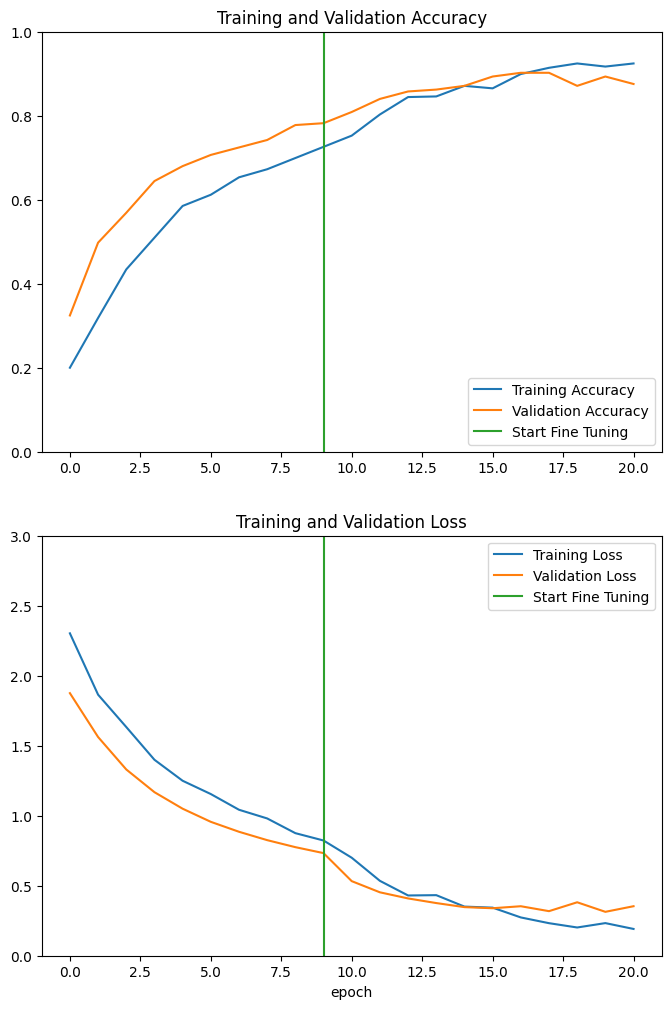

In [33]:
model_trained_on_tiny.trainig_plots()

Тестирование модели на **`test_tiny`**:

In [34]:
pred_tiny = model_trained_on_tiny.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels[:len(pred_tiny)], pred_tiny, 'test_tiny:')

  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test_tiny::
	 accuracy 0.8889:
	 balanced accuracy 0.8889:


##### Обучение модели на датасете train_small

In [13]:
model_trained_on_small = Model()
model_trained_on_small.train(d_train_small)

Epoch 1/10
169/169 [==============================] - 45s 187ms/step - loss: 1.6800 - accuracy: 0.4187 - val_loss: 0.8505 - val_accuracy: 0.7339
Epoch 2/10
169/169 [==============================] - 29s 170ms/step - loss: 0.8289 - accuracy: 0.7189 - val_loss: 0.5392 - val_accuracy: 0.8417
Epoch 3/10
169/169 [==============================] - 29s 171ms/step - loss: 0.5880 - accuracy: 0.8070 - val_loss: 0.4334 - val_accuracy: 0.8678
Epoch 4/10
169/169 [==============================] - 23s 138ms/step - loss: 0.4792 - accuracy: 0.8472 - val_loss: 0.3811 - val_accuracy: 0.8756
Epoch 5/10
169/169 [==============================] - 24s 140ms/step - loss: 0.4226 - accuracy: 0.8600 - val_loss: 0.3439 - val_accuracy: 0.8883
Epoch 6/10
169/169 [==============================] - 29s 171ms/step - loss: 0.3963 - accuracy: 0.8715 - val_loss: 0.3126 - val_accuracy: 0.8961
Epoch 7/10
169/169 [==============================] - 24s 139ms/step - loss: 0.3534 - accuracy: 0.8852 - val_loss: 0.2921 - val_ac

Кривые обучения на датасете `train_small`:

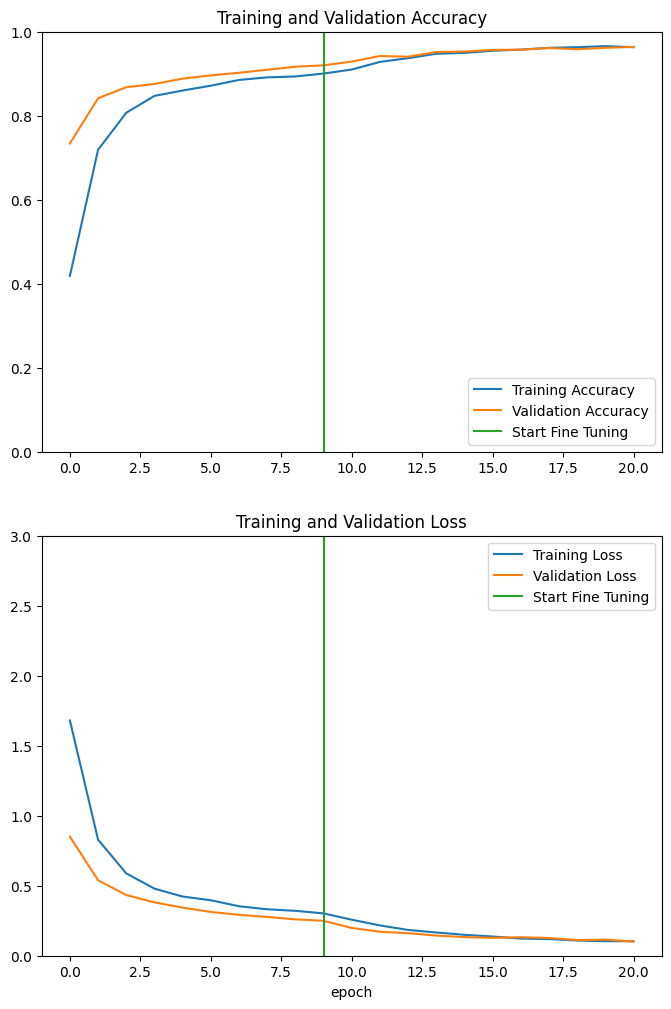

In [25]:
model_trained_on_small.trainig_plots()

Тестирование модели на **`test_small`**:

In [14]:
pred_small = model_trained_on_small.test_on_dataset(d_test_small)
Metrics.print_all(d_test_small.labels[:len(pred_small)], pred_small, 'test_small:')

  0%|          | 0/1800 [00:00<?, ?it/s]

metrics for test_small::
	 accuracy 0.9633:
	 balanced accuracy 0.9633:


Сохранение модели `model_trained_on_small`:


In [19]:
model_trained_on_small.save('small-trained')

In [20]:
model_trained_on_small_loaded = Model()
model_trained_on_small_loaded.load('small-trained')

Проверим, что работает загрузка сохраненной модели:

In [21]:
pred_small_loaded = model_trained_on_small_loaded.test_on_dataset(d_test_small)
Metrics.print_all(d_test_small.labels[:len(pred_small_loaded)], pred_small_loaded, 'loaded model on small test:')

  0%|          | 0/1800 [00:00<?, ?it/s]

metrics for loaded model on small test::
	 accuracy 0.9633:
	 balanced accuracy 0.9633:


Модель загружена. Протестируем ее на всей тестовой выборке:

In [22]:
pred_full_loaded = model_trained_on_small_loaded.test_on_dataset(d_test)
Metrics.print_all(d_test.labels[:len(pred_full_loaded)], pred_full_loaded, 'loaded model on full test:')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for loaded model on full test::
	 accuracy 0.9584:
	 balanced accuracy 0.9584:


---
###Результат:

К сожалению, обучить модель на полном датасете, используя мощности бесплатной версии гугл колаба, не удалось. Возможно обученная модель на полном датасете дала бы еще лучше результаты.

**Достигнутый accuracy:**   `0.958`


---





### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [24]:
final_model = Model()
final_model.load('small-trained')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?id=1JJABKFaDaxJsaqDG171BzcL_mVVY1HaU
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 26.4MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9778:
	 balanced accuracy 0.9778:


Отмонтировать Google Drive.

In [35]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

Function f is caluclated 128 times in 0.03265632500006177s.


### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [37]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"

[Errno 2] No such file or directory: '/content/drive/MyDrive//dl'
/content
unzip:  cannot find or open tmp.zip, tmp.zip.zip or tmp.zip.ZIP.
